In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Завантаження зображення
img = cv2.imread('../lab6_Verenchuk_Stanislav/data/document.jpg')  # або './document.jpg'
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
gray = np.float32(gray) / 255


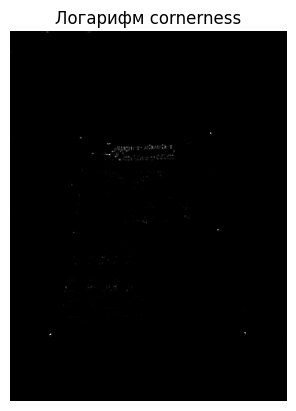

In [2]:
cornerness = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
cornerness[cornerness < 0] = 0
log_cornerness = np.log1p(cornerness)

plt.imshow(log_cornerness, cmap='gray')
plt.title('Логарифм cornerness')
plt.axis('off')
plt.show()


In [4]:
threshold = 0.01 * cornerness.max()
keypoints = np.argwhere(cornerness > threshold)


In [7]:
def descriptor_top_left(region):
    h, w = region.shape
    tl = region[:h//2, :w//2]
    tr = region[:h//2, w//2:]
    bl = region[h//2:, :w//2]
    br = region[h//2:, w//2:]
    return br.mean() - np.mean([tl.mean(), tr.mean(), bl.mean()])

In [8]:
def descriptor_top_right(region):
    h, w = region.shape
    tl = region[:h//2, :w//2]
    tr = region[:h//2, w//2:]
    bl = region[h//2:, :w//2]
    br = region[h//2:, w//2:]
    return bl.mean() - np.mean([tl.mean(), tr.mean(), br.mean()])

In [9]:
def descriptor_bottom_left(region):
    h, w = region.shape
    tl = region[:h//2, :w//2]
    tr = region[:h//2, w//2:]
    bl = region[h//2:, :w//2]
    br = region[h//2:, w//2:]
    return tr.mean() - np.mean([tl.mean(), bl.mean(), br.mean()])

In [10]:
def descriptor_bottom_right(region):
    h, w = region.shape
    tl = region[:h//2, :w//2]
    tr = region[:h//2, w//2:]
    bl = region[h//2:, :w//2]
    br = region[h//2:, w//2:]
    return tl.mean() - np.mean([tr.mean(), bl.mean(), br.mean()])

In [11]:
# Універсальна обгортка
def get_descriptor(gray_img, y, x, size=15, mode="top_left"):
    region = gray_img[y-size:y+size, x-size:x+size]
    if region.shape != (2*size, 2*size):
        return -np.inf

    if mode == "top_left":
        return descriptor_top_left(region)
    elif mode == "top_right":
        return descriptor_top_right(region)
    elif mode == "bottom_left":
        return descriptor_bottom_left(region)
    elif mode == "bottom_right":
        return descriptor_bottom_right(region)
    else:
        raise ValueError("Unknown mode!")

Top-left corner: (np.int64(115), np.int64(76))
Top-right corner: (np.int64(111), np.int64(219))
Bottom-left corner: (np.int64(330), np.int64(44))
Bottom-right corner: (np.int64(329), np.int64(255))


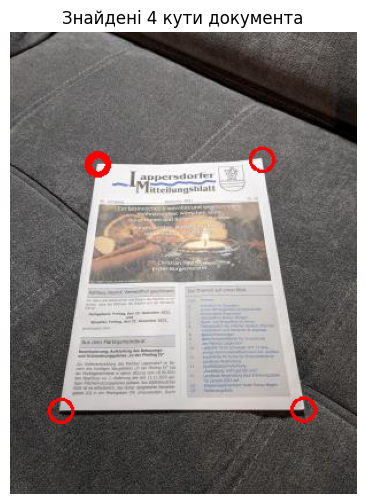

In [12]:
# Пошук найкращих кутів
top_left_candidates = [(y, x, get_descriptor(gray, y, x, mode="top_left")) for y, x in keypoints]
top_right_candidates = [(y, x, get_descriptor(gray, y, x, mode="top_right")) for y, x in keypoints]
bottom_left_candidates = [(y, x, get_descriptor(gray, y, x, mode="bottom_left")) for y, x in keypoints]
bottom_right_candidates = [(y, x, get_descriptor(gray, y, x, mode="bottom_right")) for y, x in keypoints]

top_left_point = max(top_left_candidates, key=lambda t: t[2])
top_right_point = max(top_right_candidates, key=lambda t: t[2])
bottom_left_point = max(bottom_left_candidates, key=lambda t: t[2])
bottom_right_point = max(bottom_right_candidates, key=lambda t: t[2])

# Вивід координат (опціонально)
print("Top-left corner:", top_left_point[:2])
print("Top-right corner:", top_right_point[:2])
print("Bottom-left corner:", bottom_left_point[:2])
print("Bottom-right corner:", bottom_right_point[:2])

# Візуалізація кутів
result_img = img_rgb.copy()
for (y, x, _) in [top_left_point, top_right_point, bottom_left_point, bottom_right_point]:
    cv2.circle(result_img, (x, y), 10, (255, 0, 0), 2)

plt.figure(figsize=(10, 6))
plt.imshow(result_img)
plt.title("Знайдені 4 кути документа")
plt.axis("off")
plt.show()